In [18]:
import pandas as pd
import numpy as np
print(f'Panda version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')

Panda version: 1.5.3
Numpy version: 1.23.1


# Sandbox

## Download NY street data
https://gis.ny.gov/system/files/documents/2023/03/how-to-create-county-filters-of-nys-address-point-data.pdf

## Discussion
Seq to Seq model. ~~Input and Output will both have length of 6~~

## Quesiton 1
1. ~~How to write the encoding and padding for each sub-component? Maybe don't need. I think Seq can take a whole Seq as an input and output another Seq~~
2. When inference, can we run different tokens with the next likelihood, so that we can list out 5 predictions with their relative order?

In [94]:
addr = pd.read_csv('Datasets/NYS_Address_Points.csv')

KeyboardInterrupt: 

In [ ]:
addr.columns

Index(['OBJECTID', 'NYSAddressPointID', 'CountyID', 'NYSStreetID',
       'PrefixAddressNumber', 'AddressNumber', 'SuffixAddressNumber',
       'PreModifier', 'PreDirectional', 'PreType', 'SeparatorElement',
       'StreetName', 'PostType', 'PostDirectional', 'PostModifier',
       'SubAddress', 'Structure', 'Floor', 'Unit', 'Location', 'Site',
       'SubSite', 'BusinessName', 'ZipName', 'State', 'ZipCode', 'PointType',
       'AddressSource', 'DiscrepancyAgencyID', 'DateUpdated', 'PrimaryPoint',
       'CityTownName', 'PlaceName', 'PlaceType', 'CompleteStreetName',
       'AP_Flag', 'Status', 'AddressLabel', 'CountyName',
       'CLDXF_PreDirectional', 'CLDXF_PostType', 'CLDXF_PostDirectional',
       'Country', 'ESN', 'IncorporatedMunicipality',
       'UnincorporatedMunicipality', 'NeighborhoodCommunity',
       'MSAGCommunityName', 'MilePost', 'SWIS_SBL_ID', 'SWIS_PRINT_KEY_ID',
       'MunicipalityType', 'AddressType', 'USERNAME', 'CR_USERNAME',
       'CR_DATETIME', 'AT_USERNAME

In [ ]:
addr[['AddressNumber','StreetName','PostType','CountyName','CityTownName','ZipCode','State']].head()

,AddressNumber,StreetName,PostType,CountyName,CityTownName,ZipCode,State
0,519,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
1,584,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
2,589,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
3,557,23,NaN,Cattaraugus,Coldspring,14779.0,NY
4,397,280,NaN,Cattaraugus,South Valley,14779.0,NY


In [25]:
addr['ZipName'].value_counts().head(20)

Buffalo          331767
Brooklyn         308882
Rochester        267913
Staten Island    129677
Syracuse         108095
Bronx            105995
Albany            94485
Schenectady       72789
Yonkers           67842
New York          62473
Binghamton        44513
Poughkeepsie      42436
Niagara Falls     41064
Ithaca            39302
Troy              37996
Jamaica           36382
White Plains      30314
Flushing          29999
Middletown        29875
Lockport          29259
Name: ZipName, dtype: int64

In [ ]:
addr.sample(5).to_excel('Datasets/NYS_sample.xlsx')

In [27]:
addr_debug = addr.loc[lambda x:x['CityTownName'] == 'New York'][['AddressNumber','StreetName','PostType','CountyName','CityTownName','ZipName','ZipCode','State']].copy()
addr_debug.dropna(inplace = True)
addr_debug.drop_duplicates(inplace = True)
addr_debug.to_parquet('Datasets/NYS_clean.parquet.gz')

In [57]:
addr_debug = pd.read_parquet('Datasets/NYS_clean.parquet.gz', engine='pyarrow')

In [60]:
addr_debug[['CountyName','ZipName']].drop_duplicates().value_counts().to_frame()

0
CountyName  ZipName           
Bronx       Bronx            1
Queens      Jackson Heights  1
            Kew Gardens      1
            Lawrence         1
            Little Neck      1
...                         ..
            Flushing         1
            Forest Hills     1
            Fresh Meadows    1
            Glen Oaks        1
Westchester Yonkers          1

[61 rows x 1 columns]

In [96]:
addr_debug.sample(5)

,AddressNumber,StreetName,PostType,CountyName,CityTownName,ZipName,ZipCode,State
5686141,486,Sea Breeze,Walk,Queens,New York,Breezy Point,11697.0,NY
5259547,3014,Lafayette,Ave,Bronx,New York,Bronx,10465.0,NY
5685070,10,Thetford,Ln,Queens,New York,Breezy Point,11697.0,NY
5261381,529,Brush,Ave,Bronx,New York,Bronx,10465.0,NY
5855354,718,Oakland,Ave,Richmond,New York,Staten Island,10310.0,NY


In [111]:
import random
toy = addr_debug.sample(5)
toy[['AddressNumber','StreetName','PostType','ZipName','State','ZipCode']].astype(str).apply(lambda x:','.join(x), axis = 1).apply(lambda x:x.split(','))

5753496                [2055, 73, St, Brooklyn, NY, 11204.0]
5793793                [5306, 8, Ave, Brooklyn, NY, 11220.0]
5791718               [5104, 10, Ave, Brooklyn, NY, 11219.0]
5869847    [421, Father Capodanno, Blvd, Staten Island, N...
5851025        [445, Ocean, Ter, Staten Island, NY, 10301.0]
dtype: object

In [113]:
def order_random_sample(myList,K):
    indices = random.sample(range(len(myList)), K)
    return [myList[i] for i in sorted(indices)]

toy[['AddressNumber','StreetName','PostType','ZipName','State','ZipCode']].astype(str).apply(lambda x:','.join(x), axis = 1).apply(lambda x:x.split(',')).apply(lambda x:order_random_sample(x,4))

5753496                        [73, St, Brooklyn, 11204.0]
5793793                      [5306, Brooklyn, NY, 11220.0]
5791718                       [Ave, Brooklyn, NY, 11219.0]
5869847    [421, Father Capodanno, Staten Island, 10305.0]
5851025                      [445, Ter, Staten Island, NY]
dtype: object

In [32]:
for col_i in addr_debug.columns:
    print(f'{col_i} has max length of {addr_debug[col_i].astype(str).apply(len).max()}')

AddressNumber has max length of 5
StreetName has max length of 28
PostType has max length of 6
CountyName has max length of 11
CityTownName has max length of 8
ZipName has max length of 19
ZipCode has max length of 7
State has max length of 2


In [36]:
addr_debug.loc[:,lambda x:x.columns.isin(['AddressNumber'])]

,AddressNumber
4303742,210
4303743,208
4303744,201
4303745,208
4303748,209
...,...
5942778,25
5942779,405
5942780,17
5942781,397


# Dataset Ingest Starts from Here

In [55]:
import pandas as pd
import numpy as np
print(f'Panda version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
import utils
from importlib import reload
utils = reload(utils)

Panda version: 1.5.3
Numpy version: 1.23.1


In [2]:
context_raw,target_raw = utils.create_label_target('Datasets/NYS_clean.parquet.gz')
print(f'Context shape: {context_raw.shape}')
print(f'Target shape: {target_raw.shape}')

Context shape: (100000,)
Target shape: (100000,)


In [3]:
random_numbers = np.random.choice(len(context_raw), 1)[0]
context_raw[random_numbers],target_raw[random_numbers]

('112 Narrows NY 10305', '112 Narrows Rd Staten Island NY 10305')

# Re-load Data

In [6]:
np.save("context_raw.npy", context_raw)
np.save("target_raw.npy", target_raw)

In [ ]:
context_raw = np.load("context_raw.npy")
target_raw = np.load("target_raw.npy")

In [ ]:
import h5py
# Output to HDF5 file
f = h5py.File("context_raw.h5", "w")
f["array"] = context_raw
f.close()

f = h5py.File("target_raw.h5", "w")
f["array"] = target_raw
f.close()

In [ ]:
# Open the HDF5 file
f = h5py.File("context_raw.h5", "r")
context_raw = f["array"]
f.close()

f = h5py.File("target_raw.h5", "r")
target_raw = f["array"]
f.close()

# Data Processing

In [7]:
import tensorflow as tf
import tensorflow_text as tf_text

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'78 76 St NY' b'683 Ave Ridgewood NY' b'29 St Woodside 11377'
 b'49 St NY 11204' b'Dr Staten Island NY 10314'], shape=(5,), dtype=string)

tf.Tensor(
[b'78 76 St Brooklyn NY 11209' b'683 Seneca Ave Ridgewood NY 11385'
 b'29 Hobart St Woodside NY 11377' b'1624 49 St Brooklyn NY 11204'
 b'219 Jules Dr Staten Island NY 10314'], shape=(5,), dtype=string)


In [9]:
import utils
from importlib import reload
utils = reload(utils)

example_text = tf.constant('18 Hartford Richmond Staten Island NY 10308')
print(example_text.numpy().decode())
print(utils.tf_lower_and_split_punct(example_text).numpy().decode())

18 Hartford Richmond Staten Island NY 10308
[START] 18 hartford richmond staten island ny 10308 [END]


# Text Vectorization

In [10]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [11]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'ny',
 'st',
 'brooklyn',
 'ave',
 'island',
 'staten']

In [12]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 'ny',
 '[START]',
 '[END]',
 'st',
 'brooklyn',
 'ave',
 'island',
 'staten']

In [13]:
print(example_context_strings)
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

tf.Tensor(
[b'78 76 St NY' b'683 Ave Ridgewood NY' b'29 St Woodside 11377'
 b'49 St NY 11204' b'Dr Staten Island NY 10314'
 b'1737 Undercliff NY 10453' b'Slocum Cres NY 11375' b'26 St NY 11417'
 b'Ocean Ave Brooklyn NY' b'118 St South Ozone Park NY'
 b'197 York NY 10301' b'St Brooklyn NY 11203' b'Bedford Ave NY 11210'
 b'717 Blvd Brooklyn 11213' b'Byron Ave Bronx 10466'
 b'31 36 Astoria 11103' b'400 Ave NY 11206' b'1459 St Brooklyn NY'
 b'161 75 St NY' b'18 St Brooklyn NY' b'89 St Brooklyn NY'
 b'3453 Ropes NY 10475' b'Front Staten Island NY 10304'
 b'Loop Staten Island NY 10309' b'18 Ct NY 10309' b'4 23 Ave NY'
 b'3911 Farragut NY 11210' b'Greenleaf Ave Staten Island 10310'
 b'2104 Bath Ave NY' b'1409 Vyse NY 10459' b'1017 St Brooklyn NY'
 b'938 180 St NY' b'31 Oswald Pl NY' b'217 St Brooklyn NY'
 b'74 Staten Island NY 10304' b'24 Ave Ridgewood NY' b'50 Pl NY 10031'
 b'Rathbun Staten Island NY 10312' b'5102 Fillmore Ave NY'
 b'288 Mcguinness Brooklyn NY' b'274 Lenox New York 10027'
 b

<tf.RaggedTensor [[2, 212, 214, 5, 4, 3],
 [2, 1709, 7, 32, 4, 3],
 [2, 107, 5, 182, 189, 3]]>

In [14]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 78 76 st ny [END]'

# Process Text

In [15]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

In [16]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[   2  333 4170    7    4    3    0    0]

[   3  335 4201    7    9    8    2   20    0]
[ 335 4201    7    9    8    2   20    4    0]


# Encoder

In [17]:
UNITS = 256
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = utils.ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
          texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 8)
Encoder output, shape (batch, s, units): (64, 8, 256)


In [18]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = utils.ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 8, 256)
Target sequence, shape (batch, t, units): (64, 9, 256)
Attention result, shape (batch, t, units): (64, 9, 256)
Attention weights, shape (batch, t, s):    (64, 9, 8)


In [19]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [20]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = utils.ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [21]:
decoder = Decoder(target_text_processor, UNITS)

In [49]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 8, 256)
input target tokens shape: (batch, t) (64, 9)
logits shape shape: (batch, target_vocabulary_size) (64, 9, 5000)


In [52]:
# Add method for inference
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [54]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'woodycrest astoria 1425 beverley 33 459 1463 topping arbutus 1284',
       b'arleigh 970 charlotte 2458 304 seaman cayuga taunton 1785 546',
       b'1014 mallory 1745 drake woodrow laurel 11239 10006 bragg 1627'],
      dtype=object)

# Model

In [45]:
class Addressor(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [46]:
model = Addressor(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 8)
Target tokens, shape: (batch, t) (64, 9)
logits, shape: (batch, t, target_vocabulary_size) (64, 9, 5000)


In [47]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [48]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

print(model.summary())

Model: "addressor_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  2069504   
                                                                 
 decoder_3 (Decoder)         multiple                  3223432   
                                                                 
Total params: 5,292,936
Trainable params: 5,292,936
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
100/100 [==============================] - 41s 309ms/step - loss: 3.9520 - masked_acc: 0.4416 - masked_loss: 3.9520 - val_loss: 2.8507 - val_masked_acc: 0.5416 - val_masked_loss: 2.8507
Epoch 2/10
100/100 [==============================] - 28s 281ms/step - loss: 2.4912 - masked_acc: 0.5933 - masked_loss: 2.4912 - val_loss: 2.1371 - val_masked_acc: 0.6614 - val_masked_loss: 2.1371
Epoch 3/10
100/100 [==============================] - 27s 266ms/step - loss: 1.8882 - masked_acc: 0.7131 - masked_loss: 1.8882 - val_loss: 1.6507 - val_masked_acc: 0.7512 - val_masked_loss: 1.6507
Epoch 4/10
100/100 [==============================] - 25s 247ms/step - loss: 1.5613 - masked_acc: 0.7645 - masked_loss: 1.5613 - val_loss: 1.4103 - val_masked_acc: 0.7866 - val_masked_loss: 1.4103
Epoch 5/10
100/100 [==============================] - 28s 284ms/step - loss: 1.3528 - masked_acc: 0.7947 - masked_loss: 1.3528 - val_loss: 1.2714 - val_masked_acc: 0.8009 - val_masked_loss: 1.2714
Epoch 6/10
100/

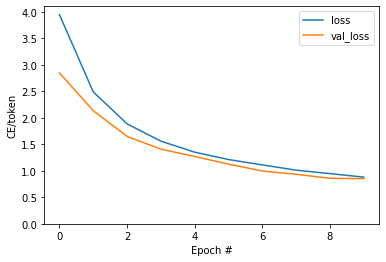

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

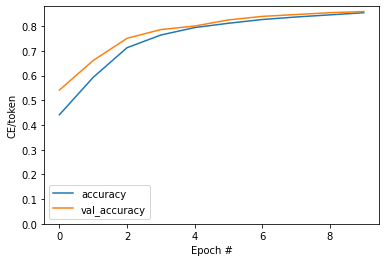

In [30]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [31]:
@Addressor.add_method
def Addressor_fix(self,
                  texts, *,
                  max_length=50,
                  temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

@Addressor.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.Addressor_fix([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = utils.tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = utils.tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

In [32]:

random_numbers = np.random.choice(len(example_context_strings), 1)[0]

for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[random_numbers:random_numbers + 5])
    print()
    print(example_target_strings[random_numbers:random_numbers + 5])
    break

tf.Tensor(
[b'438 Olmstead Bronx 10473' b'Wortman Ave NY 11207' b'12 48 Ave NY'
 b'153 Sunset Blvd Bronx' b'Southern Blvd Bronx NY'], shape=(5,), dtype=string)

tf.Tensor(
[b'438 Olmstead Ave Bronx NY 10473' b'396 Wortman Ave Brooklyn NY 11207'
 b'12 48 Ave Elmhurst NY 11373' b'153 Sunset Blvd Bronx NY 10473'
 b'571 Southern Blvd Bronx NY 10455'], shape=(5,), dtype=string)


In [44]:
context = '12 48 Ave NY'
result = model.Addressor_fix([context]) 
result

AttributeError: 'Addressor' object has no attribute 'Addressor_fix'

C:\Users\gkchen\AppData\Local\Temp/ipykernel_6696/1494989072.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\gkchen\AppData\Local\Temp/ipykernel_6696/1494989072.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


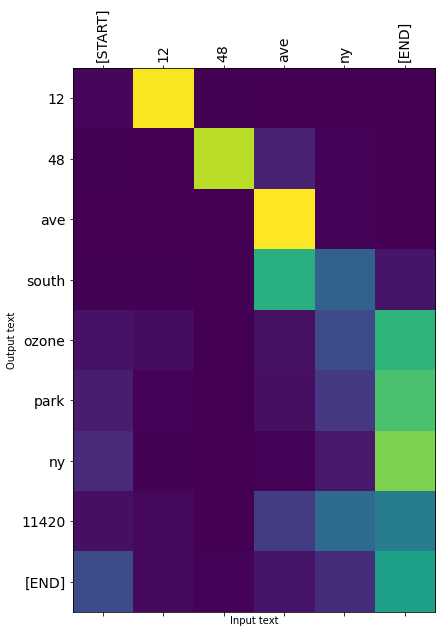

In [38]:
model.plot_attention(context)